# GitHub Data for OpenShift Origins

In this notebook we will quickly walk through how to access and start analyzing the PR data for the OpenShift origins repository. The ultimate hope for this work is that we will be able to connect the Github data (code changes) directly with the Bugs, Telemetry, TestGrid and Prow datasets in order to develop a complete picture of the OpenShift CI process.   

## Data Collection:

The Thoth team already developed a tool for collecting data and perfoming analysis on GitHub repositoreis, [MI-Scheduler](https://github.com/thoth-station/mi-scheduler). So, we will not be accessing the data directly from GitHub, but from ceph storage after requesting that the OpenShift/Origin repo be included in the MI-Scheduler tool (see [issue](https://github.com/thoth-station/mi-scheduler/issues/130) for details).    

In [1]:
import os
import gzip
import json
import boto3
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (20, 10)})

In [2]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")
s3_input_data_path = "raw_data"
REMOTE = os.getenv("REMOTE")

In [3]:
data_path = "../../../data/raw/GitHub/PullRequest.json.gz"

if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, "thoth/mi/openshift/origin/PullRequest.json")
    file = content.get()["Body"].read().decode("utf-8")
    prs = json.loads(file)

    with gzip.open(data_path, "wb") as out_file:
        out_file.write(json.dumps(prs).encode("utf-8"))

else:
    print("getting dataset from local")
    with gzip.open(data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))


pr_df = pd.DataFrame(prs).T

getting dataset from ceph


In [4]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files
26100,bug 1949306: add e2e test to block usage of re...,Right now this is set to flake in CI and provi...,XXL,deads2k,1619104429,1619253940,openshift-merge-robot,1619253940,2,135,"{'deads2k': 1, 'openshift-ci-robot': 307, 'stt...",{},"[approved, bugzilla/severity-urgent, bugzilla/...","[13b0e99d5f35d85998af9f07eb0c5b7d6fcc0dd0, 0c3...","[go.mod, go.sum, test/extended/apiserver/api_r..."
26099,bug 1951705: allow HighOverallControlPlaneCPU ...,adding the alert in https://github.com/openshi...,XS,deads2k,1619091511,1619113470,openshift-merge-robot,1619113470,1,1,"{'openshift-ci-robot': 508, 'deads2k': 43, 'op...",{},"[approved, bugzilla/severity-high, bugzilla/va...",[7bc10c83eea29010f3b735c41847d43a992f606c],[test/extended/prometheus/prometheus.go]


## Inspect the dataset

Let's unroll a single row and see what kind of information we have access to. 

In [5]:
pr = pr_df.iloc[4]
pr

title                                   Bug 1949050: fix images.sh script
body                    This is a followup to https://github.com/opens...
size                                                                    S
created_by                                                        soltysh
created_at                                                     1618993979
closed_at                                                      1619069721
closed_by                                           openshift-merge-robot
merged_at                                                      1619069721
commits_number                                                          1
changed_files_number                                                    2
interactions            {'openshift-ci-robot': 279, 'soltysh': 2, 'ope...
reviews                 {'641526396': {'author': 'adambkaplan', 'words...
labels                  [approved, bugzilla/severity-high, bugzilla/va...
commits                        [06830a

</br>

#### **Available Fields:**

* **title**: text providing a short description of the of the PR.

* **body**: text providing additional details regarding the changes. 

* **size**: categorical label generated by GitHub summerizing the size of the changes made to the code base. 

* **created/closed/merged_at**: timestamps for when the PR was opened, merged and finally closed. 

* **created/closed_by**: usernames for contributors who created the PR and closed it. 

* **commits_number**: integer indicating the number of commits in the PR.

* **changed_files_number**: integer indicating the number of files changed.

The remaining fields appear to be collections of items, let's unroll each one and see what additional information they provide.


In [6]:
pr["interactions"]

{'openshift-ci-robot': 279,
 'soltysh': 2,
 'openshift-bot': 180,
 'openshift-ci[bot]': 79}

**interactions**: a dictionary with usernames for keys and the number of times they interacted with the PR as the value.

In [7]:
pr["reviews"]

{'641526396': {'author': 'adambkaplan',
  'words_count': 1,
  'submitted_at': 1619032331,
  'state': 'APPROVED'}}

**reviews**: a dictionary of reviews that includes an id number key along with fields for author, word_count, submitted timestamp and state of review.

In [8]:
pr["labels"]

['approved', 'bugzilla/severity-high', 'bugzilla/valid-bug', 'lgtm']

**labels**: a list of labels tagged to the PR describing some of its attributes

In [9]:
pr["commits"]

['06830a927241a44ae24e9a4b5b2ac75f666d36bc']

**commits**: a list of commit hashes that point to specific changes made to the repo's history

In [10]:
print(len(pr["changed_files"]))
pr["changed_files"][0:10]

2


['test/extended/testdata/bindata.go',
 'test/extended/testdata/cmd/test/cmd/images.sh']

**changed_files**: a list of the paths and filenames for every file changed by this PR.

We now know what we have access to in this dataset. It is a collection of numerical, categorical and textual features used to describe a PR. This gives us a lot of potential avenues to explore from an EDA and Data Science perspective. But is also creates an additional challenge insofar as we'll need to do a bit of feature engineering to get this data into format that is ready to be ingested by any ML models. 

## Example feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 


**Text Fields**

There is a whole sub-field (NLP) dedicated to analyzing text and encoding it into numerical representations. However, we will use only some simple feature engineering techniques here.

**Timestamps**

When something was created or closed is somewhat arbitary outside of a timeseries analysis. Let's try and convert these values into something more comparable. We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

**New DataFrame**

We will create a new dataframe with our derived features and a subset of the only numerical features in the original dataframe, and perform some lite analysis on it.

In [18]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].astype(float)

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [19]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

**Title**

Lets try to see if there is anything useful that can be extracted from the PR title.

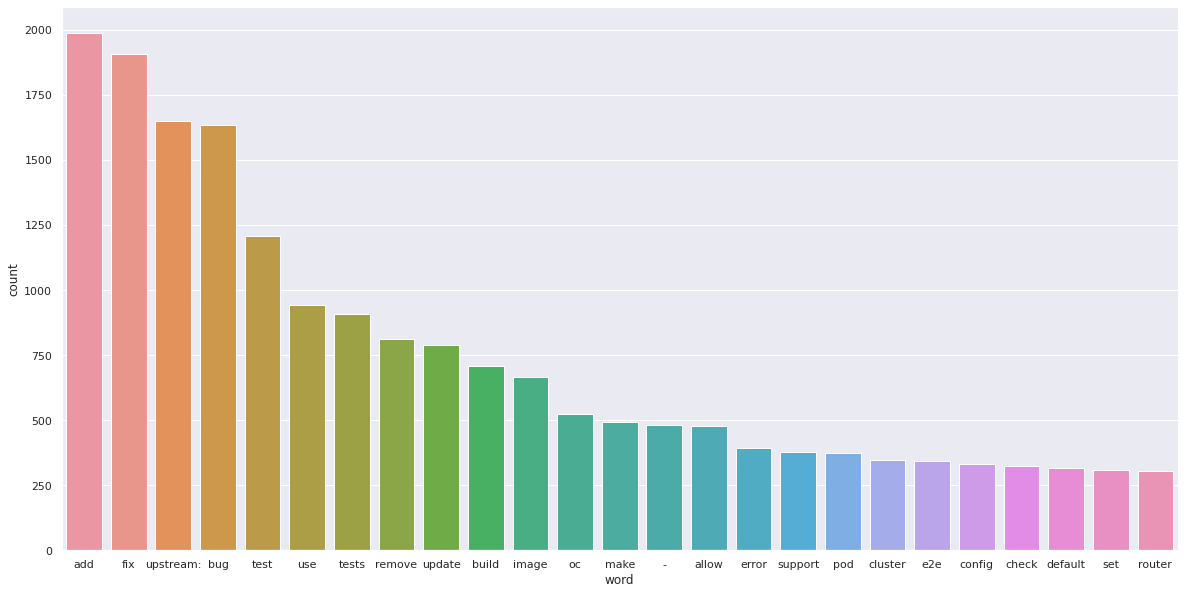

In [20]:
# what are the most commonly appearing words in the titles
words = pr_df['title'].str.lower().str.cat(sep=' ').split()
words = [w for w in words if w not in set(STOPWORDS)]

# word frequencies
values, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=values).sort_values(ascending=False)

# plot the 25 most common words
sns.barplot(
    x=vc.index[:25],
    y=vc.values[:25],
)
plt.xlabel('word')
plt.ylabel('count')
plt.show()

In [26]:
# lets see if we can gain any meaningful information about a pr based on the title

# is code being added, removed or updated?
pr_df['title_has_add'] = pr_df['title'].apply(lambda x: 'add' in x.lower().split())
pr_df['title_has_remove'] = pr_df['title'].apply(lambda x: 'remove' in x.lower().split())
pr_df['title_has_update'] = pr_df['title'].apply(lambda x: 'update' in x.lower().split())

# is something being fixed?
pr_df['title_has_fix'] = pr_df['title'].apply(lambda x: any(s in x.lower().split() for s in ['fix', 'fixes']))

# is this related to tests?
pr_df['title_has_test'] = pr_df['title'].apply(lambda x: 'test' in x.lower().split())

# is this related to upstream or release
pr_df['title_has_upstream'] = pr_df['title'].apply(lambda x: any(s in x.lower().split() for s in ['upstream', 'upstream:']))
pr_df['title_has_release'] = pr_df['title'].apply(lambda x: 'release' in x.lower().split())

# is this related to config, image, or build
pr_df['title_has_config'] = pr_df['title'].apply(lambda x: 'config' in x.lower().split())
pr_df['title_has_build'] = pr_df['title'].apply(lambda x: 'build' in x.lower().split())
pr_df['title_has_image'] = pr_df['title'].apply(lambda x: 'image' in x.lower().split())

**Created By**

Is the time taken to merge a PR affected by the author of the PR? E.g. if a code reviewer or someone who has already made several contributions to a repo creates a PR, is it likely to get merged relatively faster?

In [28]:
# approvers and reviewrs list from the repo
approvers = [
    'bparees',
    'deads2k',
    'derekwaynecarr',
    'eparis',
    'knobunc',  # Network, Multi-cluster, Storage
    'mfojtik',
    'pweil-',
    'sjenning',
    'soltysh',
    'sttts',
    'smarterclayton',
]

reviewers = [
    'bparees',
    'deads2k',
    'sjenning',
    'smarterclayton',
    'soltysh',
]

In [29]:
# is the pr creator on the approvers or reviewers list
pr_df['is_reviewer'] = pr_df['created_by'].isin(reviewers)
pr_df['is_approver'] = pr_df['created_by'].isin(approvers)

In [30]:
# how many prs did the creator create before this pr
def get_prev_pr_info(creator_pr_df):
    num_prev_merged_prs = creator_pr_df['time_to_merge'].expanding().count().shift(1).fillna(0)
    return num_prev_merged_prs

# need to sort before applying groupby
# because merging is not possible as df index types are different
pr_df = pr_df.sort_values(by='created_at')

num_prev_merged_prs = pr_df.groupby('created_by').apply(get_prev_pr_info)
num_prev_merged_prs = num_prev_merged_prs.reset_index(drop=True).rename('num_prev_prs')

pr_df['num_prev_merged_prs'] = num_prev_merged_prs.values

**Created At**

This column cann give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [31]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
)
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)
# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)
# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())
# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [32]:
pr_df.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,...,title_has_build,title_has_image,is_reviewer,is_approver,num_prev_merged_prs,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
1,Add link to GOPATH doc and fixup typo,None,XS,jwforres,1407759383,1407759502,smarterclayton,1407759502,1,1,...,False,False,False,False,0.0,2014-08-11 12:16:23,11,8,0,12
2,Add alpha API documentation,Merge of csrwng/oo-api-v3\n,XXL,csrwng,1407834992,1407844533,danmcp,1407844533,1,54,...,False,False,False,False,0.0,2014-08-12 09:16:32,12,8,1,9
3,Added etcd folder into .gitignore,,XS,mfojtik,1407836378,1407866813,smarterclayton,1407866813,1,1,...,False,False,False,True,0.0,2014-08-12 09:39:38,12,8,1,9
4,[WIP] Added project template json-schema,,L,mfojtik,1407843204,1408087830,mfojtik,None,1,1,...,False,False,False,True,0.0,2014-08-12 11:33:24,12,8,1,11
5,Add examples for pod creation,None,M,jwforres,1407846787,1407866827,smarterclayton,1407866827,1,7,...,False,False,False,False,0.0,2014-08-12 12:33:07,12,8,1,12


**Commits Number**  
Commits Number gives the number of commits created within the PR. This could be a numerical feature for our model.

In [33]:
pr_df.commits_number.value_counts()

1       13304
2        1986
3         737
4         353
5         234
        ...  
97          1
108         1
112         1
115         1
1718        1
Name: commits_number, Length: 105, dtype: int64

As we see above, in this dataset, there is not much variability in the commits number. They hold values like 1, 2. So this may not give us a lot of information. We can rather look at number of changed files for more informationn into the size of the PR.

**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [34]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1        6151
2        3046
3        1622
4        1035
5         669
         ... 
12608       1
294         1
166         1
102         1
14041       1
Name: changed_files_number, Length: 422, dtype: int64

Let's look at some pair-wise scatter plots of our data to see if there are any obvious correlations between our features. 

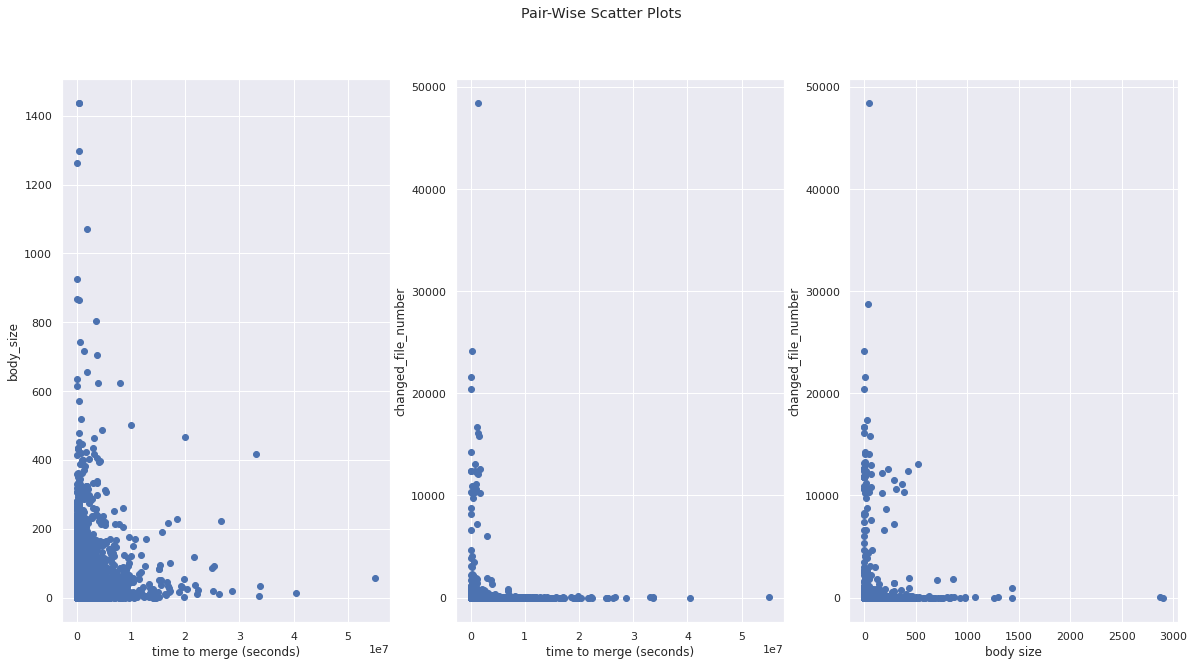

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(pr_df["time_to_merge"], pr_df["body_size"])
ax1.set(xlabel="time to merge (seconds)", ylabel="body_size")
ax2.scatter(pr_df["time_to_merge"], pr_df["changed_files_number"])
ax2.set(xlabel="time to merge (seconds)", ylabel="changed_file_number")
ax3.scatter(pr_df["body_size"], pr_df["changed_files_number"])
ax3.set(xlabel="body size", ylabel="changed_file_number")
fig.suptitle("Pair-Wise Scatter Plots")
plt.show()

In [37]:
# subset DataFrame to use as features
feature_df = pr_df[[
    "time_to_merge",
    "changed_files_number",
    "body_size",
    "title_has_add",
    "title_has_remove",
    "title_has_update",
    "title_has_fix",
    "title_has_test",
    "title_has_upstream",
    "title_has_release",
    "title_has_config",
    "title_has_build",
    "title_has_image",
    "is_reviewer",
    "is_approver",
    "num_prev_merged_prs",
    "created_at_datetime",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
    
]]

In [38]:
feature_df.head(2)

,time_to_merge,changed_files_number,body_size,title_has_add,title_has_remove,title_has_update,title_has_fix,title_has_test,title_has_upstream,title_has_release,...,title_has_build,title_has_image,is_reviewer,is_approver,num_prev_merged_prs,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
1,119.0,1,0,True,False,False,False,False,False,False,...,False,False,False,False,0.0,2014-08-11 12:16:23,11,8,0,12
2,9541.0,54,3,True,False,False,False,False,False,False,...,False,False,False,False,0.0,2014-08-12 09:16:32,12,8,1,9


In [39]:
feature_df.describe()

,time_to_merge,changed_files_number,body_size,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour
count,1.353000e+04,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000
mean,6.801719e+05,68.379910,31.476867,229.372752,15.567479,6.286970,2.128557,13.720829
std,1.848350e+06,885.774654,66.186398,322.057245,8.731051,3.314852,1.531857,5.323008
min,3.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,3.684875e+04,1.000000,3.000000,19.000000,8.000000,3.000000,1.000000,11.000000
50%,1.329870e+05,2.000000,14.000000,87.000000,16.000000,6.000000,2.000000,14.000000
75%,5.245955e+05,6.000000,36.000000,289.000000,23.000000,9.000000,3.000000,18.000000
max,5.500529e+07,48386.000000,2899.000000,1429.000000,31.000000,12.000000,6.000000,23.000000


In [40]:
feature_df.corr()

,time_to_merge,changed_files_number,body_size,title_has_add,title_has_remove,title_has_update,title_has_fix,title_has_test,title_has_upstream,title_has_release,title_has_config,title_has_build,title_has_image,is_reviewer,is_approver,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour
time_to_merge,1.000000,0.004417,0.115515,0.029514,-0.030199,-0.012980,-0.028307,-0.013004,-0.010390,-0.020958,0.014626,-0.020754,0.005468,-0.096736,-0.102332,-0.018753,0.004760,0.032109,0.008868,-0.005521
changed_files_number,0.004417,1.000000,0.028810,-0.009746,-0.003673,-0.001935,-0.023509,0.003389,-0.020123,-0.005430,-0.009426,0.013380,-0.006374,0.022640,0.038375,-0.009828,0.012326,-0.005190,0.001103,-0.004093
body_size,0.115515,0.028810,1.000000,0.005275,-0.028102,-0.021165,-0.033226,-0.005175,-0.038363,-0.011410,0.004671,-0.019859,-0.005499,-0.046570,-0.038743,-0.014049,0.003230,-0.010040,0.004392,-0.004478
title_has_add,0.029514,-0.009746,0.005275,1.000000,-0.069013,-0.058867,-0.111549,0.045017,-0.043429,0.002711,-0.005736,0.019215,0.012272,-0.025851,-0.011733,-0.010299,-0.012992,-0.004751,0.000338,0.010208
title_has_remove,-0.030199,-0.003673,-0.028102,-0.069013,1.000000,-0.044755,-0.072662,-0.001337,-0.011769,-0.015236,-0.006608,-0.015237,-0.016477,0.034338,0.032051,0.001525,0.003533,0.005265,-0.012572,-0.006390
title_has_update,-0.012980,-0.001935,-0.021165,-0.058867,-0.044755,1.000000,-0.061888,-0.015968,-0.023180,-0.002961,-0.001681,-0.011236,-0.008066,-0.021976,-0.035312,-0.028067,0.007209,0.003651,0.000537,0.008343
title_has_fix,-0.028307,-0.023509,-0.033226,-0.111549,-0.072662,-0.061888,1.000000,0.005289,0.068827,-0.009231,-0.006541,-0.026669,-0.015530,-0.107555,-0.102586,0.005518,-0.003844,0.008577,-0.010151,-0.012935
title_has_test,-0.013004,0.003389,-0.005175,0.045017,-0.001337,-0.015968,0.005289,1.000000,-0.043791,-0.016141,-0.015983,0.019112,-0.012987,0.015220,0.018704,-0.014195,0.016364,0.006537,0.013845,-0.016257
title_has_upstream,-0.010390,-0.020123,-0.038363,-0.043429,-0.011769,-0.023180,0.068827,-0.043791,1.000000,-0.028697,-0.020099,-0.067793,-0.050290,-0.000309,0.032559,-0.000458,-0.002160,0.002797,-0.010734,0.000695
title_has_release,-0.020958,-0.005430,-0.011410,0.002711,-0.015236,-0.002961,-0.009231,-0.016141,-0.028697,1.000000,-0.013140,0.003187,0.062764,0.048365,0.040049,0.009780,-0.007083,-0.006898,0.021973,-0.013301


Here we can see that body_size is _most_ correlated with time_to_merge, but 0.07 is a rather weak correlation value. This is good if we are going to use these as input features to a model, but not so good if we wanted to try and predict one value from the other two. Looks like we will need to go back and engineer some more features.

### Conlusion

This notebook walked through how to access the relevant PR data for the OpenShift Origin project we whish to analyze along with the rest of the related CI data in this project. We also outlined what is contained in each record and provided a quick demonstration of how to convert the mixed data types into numerical values for statistical analysis and eventually machine learning. 

We will continue to explore the provided data and perform additional feature engineering in a forthcoming notebook.